In [1]:
import sys
sys.path.append('../../')

In [2]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score

In [3]:
from src.utils.rle_utils import  get_img, rle_decode, make_mask, mask2rle

In [4]:
path = '../../input/understanding_cloud_organization'
img_paths = '../../input/understanding-clouds-resized'
os.listdir(path)

['train.csv', 'sample_submission.csv', 'train_images', 'test_images']

In [5]:
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [6]:
test_img_filenames = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [7]:
sub.head(12)

Image_Label EncodedPixels
0     002f507.jpg_Fish           1 1
1   002f507.jpg_Flower           1 1
2   002f507.jpg_Gravel           1 1
3    002f507.jpg_Sugar           1 1
4     0035ae9.jpg_Fish           1 1
5   0035ae9.jpg_Flower           1 1
6   0035ae9.jpg_Gravel           1 1
7    0035ae9.jpg_Sugar           1 1
8     0038327.jpg_Fish           1 1
9   0038327.jpg_Flower           1 1
10  0038327.jpg_Gravel           1 1
11   0038327.jpg_Sugar           1 1

In [8]:
test_img_filenames[:3]

array(['002f507.jpg', '0035ae9.jpg', '0038327.jpg'], dtype=object)

In [9]:
from src.postprocess.simple_postprocess import simple_post_process

In [10]:
from src.postprocess.convert_to_rectangles import rescale_array_from_centre_of_mass
from src.postprocess.local_conversion_to_rectangles import LocalBoundingBoxConverter


In [11]:
bbox_converter = LocalBoundingBoxConverter().convert_to_bounding_box

In [12]:
def postprocess_mask(mask,
                     threshold,
                     min_mask_size,
                     rescale_factor,
                     size_x,
                     size_y):
    predict, num_predict = simple_post_process(mask / 255,
                                           threshold,
                                           min_mask_size)
    predict = rescale_array_from_centre_of_mass(predict, rescale_factor)
    predict = (predict > threshold)*1
    predict = bbox_converter(predict, size_x, size_y)
    predict = (predict > threshold)*1
    return predict, num_predict


In [13]:
def encode_masks(folder, image_filenames, threshold=0.5, min_mask_size=0, rescale_factor=1., size=0):
    encoded_pixels = []
    image_id = 0
    for img_filename in tqdm.tqdm(image_filenames):
        img_array = np.load(folder + img_filename + '.npz')['arr_0']
        for i in range(4):
            sub_img = img_array[i]
            sub_img = sub_img
            if sub_img.shape != (350, 525):
                    sub_img = cv2.resize(sub_img, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)

            predict, num_predict = postprocess_mask(sub_img,threshold,min_mask_size,rescale_factor,size,size)                
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
    return encoded_pixels

In [14]:
train = pd.read_csv(f'{path}/train.csv')

In [15]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [16]:
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [17]:
def get_iou(rle_encoded_true, rle_encoded_pred):
    iou = 0
    for rle_1, rle_2 in tqdm.tqdm(zip(rle_encoded_true, rle_encoded_pred)):
        mask_1 = rle_decode(str(rle_1))
        mask_1 = cv2.resize(mask_1, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        mask_2 = rle_decode(str(rle_2),  shape=(350, 525))
        if (mask_1.sum() == 0) and (mask_2.sum() == 0):
            iou += 1
        else:
            iou += dice(mask_1, mask_2)
    return iou/len(rle_encoded_true)

In [18]:
list(range(100))[1::4]

[1,
 5,
 9,
 13,
 17,
 21,
 25,
 29,
 33,
 37,
 41,
 45,
 49,
 53,
 57,
 61,
 65,
 69,
 73,
 77,
 81,
 85,
 89,
 93,
 97]

In [19]:
def get_ious(rle_encoded_true, rle_encoded_pred):
    fish_iou = get_iou(rle_encoded_true[::4], rle_encoded_pred[::4])
    gravel_iou = get_iou(rle_encoded_true[1::4], rle_encoded_pred[1::4])
    flower_iou = get_iou(rle_encoded_true[2::4], rle_encoded_pred[2::4])
    sugar_iou = get_iou(rle_encoded_true[3::4], rle_encoded_pred[3::4])
    return fish_iou, gravel_iou, flower_iou, sugar_iou

In [20]:
#encoded_pixels_test = encode_masks('../weights/efficientnetb2/masks_test/', test_img_filenames)

In [21]:
train_img_filenames = train['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values
train_img_filenames[:10]

array(['0011165.jpg', '002be4f.jpg', '0031ae9.jpg', '0035239.jpg',
       '003994e.jpg', '00498ec.jpg', '006bf7c.jpg', '006c5a6.jpg',
       '008233e.jpg', '008a5ff.jpg'], dtype=object)

In [22]:
train['filenames'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

In [23]:
def get_rles(df, filename):
    rles = df[df['filenames']==filename]['EncodedPixels'].to_list()
    return [str(rle) for rle in rles]

In [24]:
oof_pred_fns = [name[:-4] for name in os.listdir('../../weights/kaggle_blend0710_oof')]
train_img_filenames = [filename for filename in train_img_filenames if filename in oof_pred_fns]
train_img_filenames[:10]

['0031ae9.jpg',
 '00498ec.jpg',
 '0146ef3.jpg',
 '0153a8b.jpg',
 '0187cd7.jpg',
 '0362b0a.jpg',
 '03b1dc4.jpg',
 '03c3906.jpg',
 '03ed174.jpg',
 '04029b4.jpg']

  0%|          | 0/1 [00:00<?, ?it/s]/home/max/PycharmProjects/cloud_segmentation/venv/lib/python3.6/site-packages/skimage/morphology/convex_hull.py:53: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  "Returning empty image", UserWarning)
100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


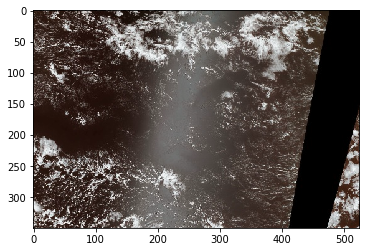

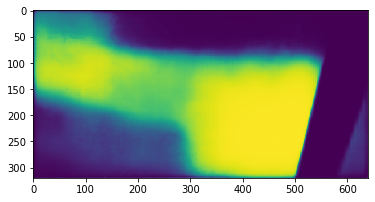

In [25]:
i = 5
image = cv2.imread('../../input/understanding-clouds-resized/test_images_525/test_images_525/' + test_img_filenames[i])
encoded_sample = encode_masks('../../weights/kaggle_blend0710_test/',
                              test_img_filenames[i:i+1],
                              threshold=0.5,
                              min_mask_size=10,
                              size=20)
original_mask = np.load('../../weights/kaggle_blend0710_test/' + test_img_filenames[i] + '.npz')['arr_0']
decoded_sample = rle_decode(encoded_sample[3],  shape=(350, 525))
plt.imshow(image)
plt.show()
plt.imshow(original_mask[3])
plt.show()
plt.imshow(rle_decode(encoded_sample[3],  shape=(350, 525)))
plt.show()
plt.imshow(image*decoded_sample[...,None])
plt.show()

In [26]:
rles = train[train['filenames']==train_img_filenames[1]]['EncodedPixels'].to_list()


In [38]:
def plot_examples(image_id= 3, sub_mask_id=0):
    train_image_filename = train_img_filenames[image_id]
    print(train_image_filename)
    rle_pred = encode_masks('../../weights/kaggle_blend0710_oof/',
                                        [train_image_filename],
                                        threshold=0.2,
                                        min_mask_size=100,
                                        rescale_factor=1.2,
                                        size=15)[sub_mask_id]
    plt.imshow(rle_decode(rle_pred,  shape=(350, 525)))
    plt.show()
    
    predicted_mask = np.load('../../weights/kaggle_blend0710_oof/' + train_image_filename + '.npz')['arr_0']
    plt.imshow(predicted_mask[sub_mask_id])
    plt.show()
    
    rle_true = get_rles(train, train_image_filename)[sub_mask_id]
    real_mask = rle_decode(rle_true)
    plt.imshow(real_mask)
    plt.show()

    image = cv2.imread('../../input/understanding-clouds-resized/train_images_525/train_images_525/' + train_img_filenames[image_id])
    plt.imshow(image)
    plt.show()
    return rle_true, rle_pred


  0%|          | 0/1 [00:00<?, ?it/s]

0031ae9.jpg


100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


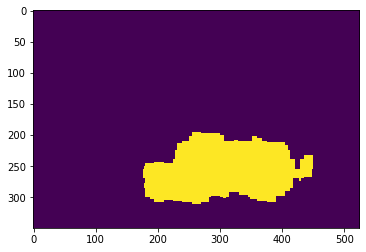

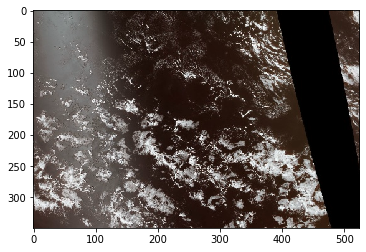

1it [00:00, 157.04it/s]


0.43663074236859534

In [39]:
rle_true, rle_pred = plot_examples(image_id= 0, sub_mask_id = 0)
get_iou([rle_true], [rle_pred])

In [29]:
hist = [[] for _ in range(4)]
subsample = 150
subsample_image_filenames = train_img_filenames[:subsample]

rles_true = [get_rles(train, filename) for filename in subsample_image_filenames]
rle_true = [item for sublist in rles_true for item in sublist]

for t in range(40, 65, 5):
    t /= 100
    for ms in [0, 100, 1200, 5000]:
        for rescale_factor in [1., 1.05, 1.1]:
            for size in [0]:#, 30, 60, 80]:
                encoded_pixels_train = encode_masks('../../weights/kaggle_blend0710_oof/',
                                                    subsample_image_filenames,
                                                    threshold=t,
                                                    min_mask_size=ms,
                                                    rescale_factor=rescale_factor,
                                                    size=size)
                ious = get_ious(rle_true, encoded_pixels_train)
                [class_hist.append([t, ms, rescale_factor, size, iou]) for class_hist, iou in zip(hist, ious)]
                print(ious)


100%|██████████| 150/150 [00:02<00:00, 69.09it/s]
150it [00:00, 275.72it/s]
150it [00:00, 286.79it/s]
150it [00:00, 290.88it/s]
150it [00:00, 257.69it/s]
  1%|▏         | 2/150 [00:00<00:08, 18.38it/s]

(0.5432732306355799, 0.741483676577756, 0.6045563703003791, 0.5405337771267769)


100%|██████████| 150/150 [00:12<00:00, 11.98it/s]
150it [00:00, 276.98it/s]
150it [00:00, 286.83it/s]
150it [00:00, 291.74it/s]
150it [00:00, 261.20it/s]
  1%|▏         | 2/150 [00:00<00:07, 18.82it/s]

(0.5478892348010881, 0.7434293729334628, 0.6047113467248431, 0.5351858478795347)


100%|██████████| 150/150 [00:12<00:00, 12.32it/s]
150it [00:00, 269.43it/s]
150it [00:00, 283.88it/s]
150it [00:00, 286.50it/s]
150it [00:00, 258.82it/s]
  5%|▌         | 8/150 [00:00<00:01, 71.02it/s]

(0.5502257696272291, 0.7438188869499923, 0.6039006738614354, 0.5296583778851973)


100%|██████████| 150/150 [00:02<00:00, 69.46it/s]
150it [00:00, 271.88it/s]
150it [00:00, 287.77it/s]
150it [00:00, 295.53it/s]
150it [00:00, 258.08it/s]
  1%|▏         | 2/150 [00:00<00:08, 18.27it/s]

(0.543161256193129, 0.7480312164143269, 0.6244320958416509, 0.5405289555940983)


100%|██████████| 150/150 [00:12<00:00, 12.20it/s]
150it [00:00, 275.56it/s]
150it [00:00, 287.86it/s]
150it [00:00, 292.75it/s]
150it [00:00, 262.98it/s]
  1%|▏         | 2/150 [00:00<00:07, 18.85it/s]

(0.5477371757775574, 0.7499901997011088, 0.6246289717126255, 0.5351864720306989)


100%|██████████| 150/150 [00:11<00:00, 12.70it/s]
150it [00:00, 278.48it/s]
150it [00:00, 288.46it/s]
150it [00:00, 297.19it/s]
150it [00:00, 265.27it/s]
  5%|▌         | 8/150 [00:00<00:01, 75.07it/s]

(0.5500661861336589, 0.7503743484182196, 0.6238546103069594, 0.529640764934912)


100%|██████████| 150/150 [00:02<00:00, 72.33it/s]
150it [00:00, 276.62it/s]
150it [00:00, 288.26it/s]
150it [00:00, 295.96it/s]
150it [00:00, 262.60it/s]
  1%|▏         | 2/150 [00:00<00:07, 18.83it/s]

(0.5623606234397809, 0.7544269146337438, 0.6376289294464208, 0.560436760741762)


100%|██████████| 150/150 [00:11<00:00, 12.63it/s]
150it [00:00, 279.07it/s]
150it [00:00, 284.91it/s]
150it [00:00, 295.74it/s]
150it [00:00, 259.66it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.01it/s]

(0.5668315867261648, 0.7563300844198898, 0.638069137354827, 0.5551097439228385)


100%|██████████| 150/150 [00:11<00:00, 12.86it/s]
150it [00:00, 270.54it/s]
150it [00:00, 284.80it/s]
150it [00:00, 296.19it/s]
150it [00:00, 261.79it/s]
  5%|▌         | 8/150 [00:00<00:01, 73.43it/s]

(0.5690660322626575, 0.7566903688838716, 0.6374595115232167, 0.5495723303241181)


100%|██████████| 150/150 [00:02<00:00, 71.24it/s]
150it [00:00, 274.41it/s]
150it [00:00, 286.79it/s]
150it [00:00, 294.68it/s]
150it [00:00, 262.42it/s]
  1%|▏         | 2/150 [00:00<00:07, 18.77it/s]

(0.5945608330365559, 0.7594592242590754, 0.6443263691578689, 0.5881163669140133)


100%|██████████| 150/150 [00:11<00:00, 13.14it/s]
150it [00:00, 270.35it/s]
150it [00:00, 285.09it/s]
150it [00:00, 292.44it/s]
150it [00:00, 260.42it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.04it/s]

(0.5987946363534372, 0.7611349882168239, 0.6447352133004345, 0.5816073066501054)


100%|██████████| 150/150 [00:11<00:00, 13.24it/s]
150it [00:00, 274.50it/s]
150it [00:00, 281.92it/s]
150it [00:00, 292.50it/s]
150it [00:00, 262.25it/s]
  5%|▍         | 7/150 [00:00<00:02, 69.96it/s]

(0.600939726264682, 0.7612748857387327, 0.6441088707430697, 0.5760480676467672)


100%|██████████| 150/150 [00:02<00:00, 71.78it/s]
150it [00:00, 274.33it/s]
150it [00:00, 277.61it/s]
150it [00:00, 292.12it/s]
150it [00:00, 255.61it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.26it/s]

(0.5361508105146117, 0.7415022308795739, 0.6242691803577872, 0.5762560581054981)


100%|██████████| 150/150 [00:11<00:00, 12.76it/s]
150it [00:00, 271.71it/s]
150it [00:00, 278.59it/s]
150it [00:00, 284.16it/s]
150it [00:00, 261.13it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.65it/s]

(0.5412546565441956, 0.7450640480798765, 0.6256739071451906, 0.5719781673986538)


100%|██████████| 150/150 [00:11<00:00, 13.11it/s]
150it [00:00, 277.22it/s]
150it [00:00, 278.53it/s]
150it [00:00, 295.78it/s]
150it [00:00, 263.14it/s]
  5%|▌         | 8/150 [00:00<00:01, 74.20it/s]

(0.5442453625086688, 0.7466717806627169, 0.6259274677505947, 0.5674585049779091)


100%|██████████| 150/150 [00:02<00:00, 73.30it/s]
150it [00:00, 272.07it/s]
150it [00:00, 259.85it/s]
150it [00:00, 275.36it/s]
150it [00:00, 262.01it/s]
  1%|▏         | 2/150 [00:00<00:08, 18.16it/s]

(0.5626782358244902, 0.7547801223778791, 0.6375917198012566, 0.5761985674879919)


100%|██████████| 150/150 [00:11<00:00, 12.77it/s]
150it [00:00, 271.93it/s]
150it [00:00, 277.69it/s]
150it [00:00, 286.34it/s]
150it [00:00, 256.13it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.82it/s]

(0.5677629492790837, 0.7583512490643437, 0.6390051934581176, 0.57191655597098)


100%|██████████| 150/150 [00:11<00:00, 13.09it/s]
150it [00:00, 234.94it/s]
150it [00:00, 228.47it/s]
150it [00:00, 258.75it/s]
150it [00:00, 250.22it/s]
  5%|▌         | 8/150 [00:00<00:01, 76.02it/s]

(0.5707213280023176, 0.759960247181623, 0.6392657603025206, 0.5674304117054103)


100%|██████████| 150/150 [00:02<00:00, 73.25it/s]
150it [00:00, 261.98it/s]
150it [00:00, 275.34it/s]
150it [00:00, 293.79it/s]
150it [00:00, 240.65it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.09it/s]

(0.575714055162638, 0.7546846102538656, 0.6375917198012566, 0.58970417296742)


100%|██████████| 150/150 [00:12<00:00, 11.73it/s]
150it [00:00, 242.64it/s]
150it [00:00, 252.42it/s]
150it [00:00, 228.59it/s]
150it [00:00, 223.81it/s]
  1%|▏         | 2/150 [00:00<00:09, 15.05it/s]

(0.5808052607803017, 0.7582460009706609, 0.6390051934581176, 0.5853704531397487)


100%|██████████| 150/150 [00:12<00:00, 12.38it/s]
150it [00:00, 271.31it/s]
150it [00:00, 289.41it/s]
150it [00:00, 292.94it/s]
150it [00:00, 260.99it/s]
  5%|▌         | 8/150 [00:00<00:01, 75.66it/s]

(0.5837655882714111, 0.7598542908799316, 0.6392657603025206, 0.5808853844174368)


100%|██████████| 150/150 [00:02<00:00, 73.54it/s]
150it [00:00, 281.29it/s]
150it [00:00, 289.65it/s]
150it [00:00, 294.00it/s]
150it [00:00, 255.86it/s]
  2%|▏         | 3/150 [00:00<00:07, 19.42it/s]

(0.5812566957771562, 0.7596975589380173, 0.6551983373997639, 0.6168125804329673)


100%|██████████| 150/150 [00:11<00:00, 13.22it/s]
150it [00:00, 286.80it/s]
150it [00:00, 296.56it/s]
150it [00:00, 305.08it/s]
150it [00:00, 270.70it/s]
  2%|▏         | 3/150 [00:00<00:07, 20.13it/s]

(0.5860066863950515, 0.7630965676249563, 0.6563811562192434, 0.6116163563648229)


100%|██████████| 150/150 [00:10<00:00, 14.28it/s]
150it [00:00, 280.73it/s]
150it [00:00, 282.97it/s]
150it [00:00, 299.13it/s]
150it [00:00, 241.55it/s]
  5%|▌         | 8/150 [00:00<00:01, 73.10it/s]

(0.5888265612957279, 0.7644965685634759, 0.6564436585196491, 0.6068585283243854)


100%|██████████| 150/150 [00:02<00:00, 63.62it/s]
150it [00:00, 259.32it/s]
150it [00:00, 277.44it/s]
150it [00:00, 289.13it/s]
150it [00:00, 257.74it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.72it/s]

(0.5450186820281543, 0.7421641738728871, 0.6239686309771297, 0.5806908702393248)


100%|██████████| 150/150 [00:11<00:00, 13.38it/s]
150it [00:00, 275.50it/s]
150it [00:00, 287.88it/s]
150it [00:00, 298.83it/s]
150it [00:00, 265.27it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.84it/s]

(0.5503336467076366, 0.7465983940592149, 0.6259413717283303, 0.5843169859111808)


100%|██████████| 150/150 [00:11<00:00, 13.59it/s]
150it [00:00, 248.42it/s]
150it [00:00, 250.99it/s]
150it [00:00, 277.49it/s]
150it [00:00, 244.98it/s]
  5%|▌         | 8/150 [00:00<00:01, 76.55it/s]

(0.553846553483025, 0.7496337962294568, 0.627197227476679, 0.5804187927076927)


100%|██████████| 150/150 [00:02<00:00, 71.37it/s]
150it [00:00, 263.00it/s]
150it [00:00, 258.73it/s]
150it [00:00, 300.17it/s]
150it [00:00, 249.73it/s]
  1%|▏         | 2/150 [00:00<00:08, 16.53it/s]

(0.5648198029192578, 0.7487183598588573, 0.6305640286211006, 0.6006964162094498)


100%|██████████| 150/150 [00:10<00:00, 13.81it/s]
150it [00:00, 264.42it/s]
150it [00:00, 265.74it/s]
150it [00:00, 285.65it/s]
150it [00:00, 266.30it/s]
  2%|▏         | 3/150 [00:00<00:07, 18.78it/s]

(0.5700882090606896, 0.7531623689430508, 0.6324974082912255, 0.5976935286978737)


100%|██████████| 150/150 [00:11<00:00, 13.37it/s]
150it [00:00, 276.56it/s]
150it [00:00, 290.32it/s]
150it [00:00, 302.62it/s]
150it [00:00, 266.18it/s]
  6%|▌         | 9/150 [00:00<00:01, 85.05it/s]

(0.5736003281437854, 0.7561918098567383, 0.6337613420251741, 0.5937972906008239)


100%|██████████| 150/150 [00:01<00:00, 75.96it/s]
150it [00:00, 287.72it/s]
150it [00:00, 284.05it/s]
150it [00:00, 303.01it/s]
150it [00:00, 248.65it/s]
  2%|▏         | 3/150 [00:00<00:07, 20.20it/s]

(0.5846250076495986, 0.7550929170656661, 0.6432421098578197, 0.6075093233564385)


100%|██████████| 150/150 [00:11<00:00, 13.52it/s]
150it [00:00, 263.17it/s]
150it [00:00, 269.07it/s]
150it [00:00, 282.94it/s]
150it [00:00, 267.99it/s]
  2%|▏         | 3/150 [00:00<00:07, 20.35it/s]

(0.5898706716309097, 0.7595080704741393, 0.6451550534491295, 0.6042007982374065)


100%|██████████| 150/150 [00:10<00:00, 14.16it/s]
150it [00:00, 268.50it/s]
150it [00:00, 265.00it/s]
150it [00:00, 294.08it/s]
150it [00:00, 229.10it/s]
  5%|▌         | 8/150 [00:00<00:01, 75.30it/s]

(0.5933575690609183, 0.7625129851980619, 0.6463233192448328, 0.6003076020799908)


100%|██████████| 150/150 [00:02<00:00, 67.84it/s]
150it [00:00, 281.27it/s]
150it [00:00, 291.78it/s]
150it [00:00, 306.53it/s]
150it [00:00, 269.23it/s]
  2%|▏         | 3/150 [00:00<00:06, 24.42it/s]

(0.5902535890551268, 0.7526701271054803, 0.6666826824549805, 0.6269784312325473)


100%|██████████| 150/150 [00:10<00:00, 14.13it/s]
150it [00:00, 281.94it/s]
150it [00:00, 292.32it/s]
150it [00:00, 282.40it/s]
150it [00:00, 270.90it/s]
  2%|▏         | 3/150 [00:00<00:06, 24.23it/s]

(0.5953935670019047, 0.7569233092548081, 0.6685005542912594, 0.6233038009509899)


100%|██████████| 150/150 [00:10<00:00, 14.50it/s]
150it [00:00, 288.67it/s]
150it [00:00, 290.63it/s]
150it [00:00, 297.06it/s]
150it [00:00, 269.51it/s]
  6%|▌         | 9/150 [00:00<00:01, 81.56it/s]

(0.5987629857844493, 0.7597258032671206, 0.6695163404364544, 0.6191904426888771)


100%|██████████| 150/150 [00:01<00:00, 77.42it/s]
150it [00:00, 268.13it/s]
150it [00:00, 248.99it/s]
150it [00:00, 280.29it/s]
150it [00:00, 246.82it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.94it/s]

(0.5539595047461824, 0.7289014821468197, 0.6318862247712348, 0.6013872750039649)


100%|██████████| 150/150 [00:10<00:00, 14.08it/s]
150it [00:00, 282.08it/s]
150it [00:00, 285.48it/s]
150it [00:00, 298.92it/s]
150it [00:00, 270.20it/s]
  2%|▏         | 3/150 [00:00<00:07, 20.70it/s]

(0.5661514743070545, 0.7337771103410825, 0.6349984275843469, 0.5995178118557462)


100%|██████████| 150/150 [00:10<00:00, 14.52it/s]
150it [00:00, 249.41it/s]
150it [00:00, 288.94it/s]
150it [00:00, 292.32it/s]
150it [00:00, 263.97it/s]
  6%|▌         | 9/150 [00:00<00:01, 83.70it/s]

(0.5638460966039746, 0.7378144221506969, 0.6370953271737576, 0.5961539519168711)


100%|██████████| 150/150 [00:01<00:00, 77.03it/s]
150it [00:00, 259.05it/s]
150it [00:00, 287.62it/s]
150it [00:00, 303.47it/s]
150it [00:00, 274.51it/s]
  2%|▏         | 3/150 [00:00<00:07, 20.62it/s]

(0.5671968648455114, 0.728768947485882, 0.6449670964086414, 0.6013417781834205)


100%|██████████| 150/150 [00:10<00:00, 13.94it/s]
150it [00:00, 252.17it/s]
150it [00:00, 287.69it/s]
150it [00:00, 293.43it/s]
150it [00:00, 247.13it/s]
  1%|▏         | 2/150 [00:00<00:07, 19.89it/s]

(0.5727733424407118, 0.7336484428995642, 0.6481287395721279, 0.5994420705060799)


100%|██████████| 150/150 [00:10<00:00, 14.42it/s]
150it [00:00, 272.13it/s]
150it [00:00, 293.31it/s]
150it [00:00, 306.84it/s]
150it [00:00, 272.07it/s]
  6%|▌         | 9/150 [00:00<00:01, 84.46it/s]

(0.577137027063068, 0.7376716651108004, 0.6502109595918956, 0.5960647863922426)


100%|██████████| 150/150 [00:01<00:00, 76.17it/s]
150it [00:00, 272.01it/s]
150it [00:00, 295.01it/s]
150it [00:00, 301.65it/s]
150it [00:00, 267.13it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.06it/s]

(0.5737117133663334, 0.7286659381185739, 0.6504887298325615, 0.6140685611152488)


100%|██████████| 150/150 [00:10<00:00, 14.23it/s]
150it [00:00, 258.64it/s]
150it [00:00, 253.09it/s]
150it [00:00, 305.22it/s]
150it [00:00, 239.18it/s]
  2%|▏         | 3/150 [00:00<00:06, 24.36it/s]

(0.5792982475170304, 0.7335401478789, 0.6535286998213552, 0.6120639691499008)


100%|██████████| 150/150 [00:10<00:00, 13.80it/s]
150it [00:00, 250.34it/s]
150it [00:00, 261.03it/s]
150it [00:00, 298.07it/s]
150it [00:00, 245.50it/s]
  6%|▌         | 9/150 [00:00<00:01, 81.79it/s]

(0.5836778732743566, 0.7375538455003215, 0.6555459345553302, 0.6086535837200474)


100%|██████████| 150/150 [00:01<00:00, 76.21it/s]
150it [00:00, 289.80it/s]
150it [00:00, 274.14it/s]
150it [00:00, 247.87it/s]
150it [00:00, 231.36it/s]
  2%|▏         | 3/150 [00:00<00:06, 23.67it/s]

(0.5899401062625496, 0.7277097068508489, 0.6561679895286358, 0.6589316903859177)


100%|██████████| 150/150 [00:10<00:00, 14.70it/s]
150it [00:00, 282.02it/s]
150it [00:00, 288.67it/s]
150it [00:00, 299.39it/s]
150it [00:00, 269.74it/s]
  2%|▏         | 3/150 [00:00<00:06, 24.30it/s]

(0.5951324347930205, 0.7324154007406559, 0.6590424081671126, 0.6571320041822855)


100%|██████████| 150/150 [00:09<00:00, 16.13it/s]
150it [00:00, 289.07it/s]
150it [00:00, 299.02it/s]
150it [00:00, 306.79it/s]
150it [00:00, 275.81it/s]
  5%|▌         | 8/150 [00:00<00:01, 75.43it/s]

(0.5991297724530924, 0.7362662140982019, 0.6609581356804742, 0.653675449626868)


100%|██████████| 150/150 [00:02<00:00, 73.08it/s]
150it [00:00, 248.06it/s]
150it [00:00, 238.50it/s]
150it [00:00, 261.30it/s]
150it [00:00, 260.44it/s]
  2%|▏         | 3/150 [00:00<00:05, 26.29it/s]

(0.5485764520463177, 0.6932168224589197, 0.6038189911330513, 0.5997726382154415)


100%|██████████| 150/150 [00:09<00:00, 15.31it/s]
150it [00:00, 263.61it/s]
150it [00:00, 283.28it/s]
150it [00:00, 300.84it/s]
150it [00:00, 267.31it/s]
  2%|▏         | 3/150 [00:00<00:06, 22.85it/s]

(0.5538789375809626, 0.6984733082008681, 0.6078938048867972, 0.6066939680626617)


100%|██████████| 150/150 [00:09<00:00, 15.12it/s]
150it [00:00, 273.84it/s]
150it [00:00, 288.43it/s]
150it [00:00, 300.58it/s]
150it [00:00, 265.03it/s]
  5%|▌         | 8/150 [00:00<00:01, 73.52it/s]

(0.5582945138362495, 0.7029951537423155, 0.6114391423884297, 0.604162838443982)


100%|██████████| 150/150 [00:01<00:00, 79.16it/s]
150it [00:00, 251.81it/s]
150it [00:00, 279.53it/s]
150it [00:00, 294.28it/s]
150it [00:00, 257.07it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.31it/s]

(0.568299959117489, 0.6930449389593311, 0.6100991293610097, 0.6063261847220329)


100%|██████████| 150/150 [00:09<00:00, 15.03it/s]
150it [00:00, 272.44it/s]
150it [00:00, 285.45it/s]
150it [00:00, 296.54it/s]
150it [00:00, 264.27it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.68it/s]

(0.5736591143396523, 0.6983510770465432, 0.61422983758486, 0.6065935957599996)


100%|██████████| 150/150 [00:09<00:00, 15.31it/s]
150it [00:00, 258.16it/s]
150it [00:00, 280.15it/s]
150it [00:00, 292.05it/s]
150it [00:00, 258.31it/s]
  5%|▌         | 8/150 [00:00<00:02, 70.97it/s]

(0.5780479557875843, 0.7028798273185977, 0.6177678809030844, 0.6040436713669591)


100%|██████████| 150/150 [00:01<00:00, 79.09it/s]
150it [00:00, 279.57it/s]
150it [00:00, 283.01it/s]
150it [00:00, 293.60it/s]
150it [00:00, 260.94it/s]
  2%|▏         | 3/150 [00:00<00:06, 24.12it/s]

(0.5671590757183141, 0.69239385789378, 0.6162510254188092, 0.6328761095795042)


100%|██████████| 150/150 [00:09<00:00, 15.98it/s]
150it [00:00, 271.45it/s]
150it [00:00, 277.54it/s]
150it [00:00, 291.71it/s]
150it [00:00, 255.57it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.31it/s]

(0.5724425659295657, 0.6976874012126854, 0.6203356117141742, 0.6332963616820523)


100%|██████████| 150/150 [00:09<00:00, 16.63it/s]
150it [00:00, 251.15it/s]
150it [00:00, 279.31it/s]
150it [00:00, 295.90it/s]
150it [00:00, 257.81it/s]
  5%|▍         | 7/150 [00:00<00:02, 68.48it/s]

(0.5767555215146775, 0.7021941542686556, 0.6238224491623853, 0.6307536157576855)


100%|██████████| 150/150 [00:01<00:00, 77.30it/s]
150it [00:00, 274.33it/s]
150it [00:00, 267.72it/s]
150it [00:00, 289.97it/s]
150it [00:00, 260.24it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.34it/s]

(0.5771496586804804, 0.6855470526157066, 0.6125514256241277, 0.6531754703156228)


100%|██████████| 150/150 [00:08<00:00, 17.28it/s]
150it [00:00, 280.99it/s]
150it [00:00, 282.00it/s]
150it [00:00, 283.81it/s]
150it [00:00, 256.79it/s]
  2%|▏         | 3/150 [00:00<00:05, 25.31it/s]

(0.5822438573345935, 0.6903090421217475, 0.6164377630785476, 0.6519395226435992)


100%|██████████| 150/150 [00:08<00:00, 17.54it/s]
150it [00:00, 270.94it/s]
150it [00:00, 279.02it/s]
150it [00:00, 294.18it/s]
150it [00:00, 263.47it/s]

(0.5862593851646756, 0.6941593873700725, 0.6196069165921199, 0.6487766327843097)


In [30]:
best_stats = [class_hist[np.argmax(np.array([stats[-1] for stats in class_hist]))] for class_hist in hist]
best_stats
# Public kernel (turbo charging):
# 0.40  25000  0.611400,
# 0.55  22500  0.744634,
# 0.50  20000  0.607715,
# 0.25  10000  0.602469

[[0.4, 5000, 1.1, 0, 0.600939726264682],
 [0.45, 5000, 1.1, 0, 0.7644965685634759],
 [0.5, 5000, 1.1, 0, 0.6695163404364544],
 [0.55, 5000, 1.0, 0, 0.6589316903859177]]

In [31]:
encoded_pixels_pred = []
encoded_pixels_true = []

rles_true = [get_rles(train, filename) for filename in train_img_filenames]
rles_true = [item for sublist in rles_true for item in sublist]

for i, class_best_stats in enumerate(best_stats):
    class_hist = []
    encoded_pixels_true += rles_true[i::4]
    encoded_pixels_train = encode_masks('../../weights/kaggle_blend0710_oof/',
                                        train_img_filenames,
                                        threshold=class_best_stats[0],
                                        min_mask_size=class_best_stats[1],
                                        rescale_factor=class_best_stats[2],
                                        size=class_best_stats[3],
                                        )
    encoded_pixels_pred += encoded_pixels_train[i::4]
    iou = get_iou(rles_true[i::4], encoded_pixels_train[i::4])
    print(iou)

iou = get_iou(encoded_pixels_true, encoded_pixels_pred)
print(iou)

100%|██████████| 1111/1111 [01:22<00:00, 13.46it/s]
1111it [00:04, 264.83it/s]
  0%|          | 2/1111 [00:00<00:57, 19.30it/s]

0.6241352908495176


100%|██████████| 1111/1111 [01:20<00:00, 13.76it/s]
1111it [00:03, 283.64it/s]
  0%|          | 3/1111 [00:00<00:45, 24.22it/s]

0.7909104127663257


100%|██████████| 1111/1111 [01:14<00:00, 14.87it/s]
1111it [00:04, 259.05it/s]
  1%|          | 8/1111 [00:00<00:14, 78.25it/s]

0.618721895405035


100%|██████████| 1111/1111 [00:14<00:00, 77.67it/s]
1111it [00:05, 221.42it/s]
24it [00:00, 239.51it/s]

0.6195142275245534


4444it [00:18, 240.85it/s]

0.6633204566363594


In [32]:
encoded_pixels_test = ['' for _ in range(4 * len(test_img_filenames))]

for i, class_best_stats in enumerate(best_stats):
    class_hist = []
    class_subsample_image_filenames = train_img_filenames[i::4]
    encoded_pixels_test_subset = encode_masks('../../weights/kaggle_blend0710_test/',
                                                test_img_filenames,
                                                threshold=class_best_stats[0],
                                                min_mask_size=class_best_stats[1],
                                                rescale_factor=class_best_stats[2],
                                                size=class_best_stats[3],
                                                )
    encoded_pixels_test[i::4] = encoded_pixels_test_subset[i::4]

100%|██████████| 3698/3698 [00:50<00:00, 72.82it/s]


In [33]:
plt.hist([len(str(rle)) for rle in train['EncodedPixels'].to_list()])

(array([1.1415e+04, 3.9110e+03, 2.9160e+03, 1.8970e+03, 1.1480e+03,
        5.7500e+02, 2.5500e+02, 5.6000e+01, 9.0000e+00, 2.0000e+00]),
 array([3.00000e+00, 6.91430e+03, 1.38256e+04, 2.07369e+04, 2.76482e+04,
        3.45595e+04, 4.14708e+04, 4.83821e+04, 5.52934e+04, 6.22047e+04,
        6.91160e+04]),
 <a list of 10 Patch objects>)

In [34]:
plt.hist([len(rle) for rle in encoded_pixels_train])

(array([2584.,  414.,  497.,  356.,  320.,  212.,   44.,   10.,    4.,
           3.]),
 array([   0. ,  998.1, 1996.2, 2994.3, 3992.4, 4990.5, 5988.6, 6986.7,
        7984.8, 8982.9, 9981. ]),
 <a list of 10 Patch objects>)

In [35]:
plt.hist([len(rle) for rle in encoded_pixels_test])

(array([7.908e+03, 1.417e+03, 1.748e+03, 1.491e+03, 1.413e+03, 6.670e+02,
        1.100e+02, 3.000e+01, 5.000e+00, 3.000e+00]),
 array([    0. ,  1052.3,  2104.6,  3156.9,  4209.2,  5261.5,  6313.8,
         7366.1,  8418.4,  9470.7, 10523. ]),
 <a list of 10 Patch objects>)

In [36]:
sub['EncodedPixels'] = encoded_pixels_test
sub.to_csv('../../weights/blended_submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [37]:
# Leaderboard: 0.603